In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import imageio
import os
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.patches import Rectangle

In [2]:
coefMat = pd.read_csv('coefficient matrix.csv')
data = pd.read_csv('50elefin.csv')
data.Date = pd.to_datetime(data.Date)
frm = pd.read_csv('50elefin_63/full_lambda.csv', index_col=0)
frm.index = pd.to_datetime(frm.index)
frm_flat = frm.values.flatten()
macro = pd.read_csv('macro_return.csv')
lambdas = pd.read_csv('full_lambda.csv')

In [4]:
frames = []

for date in data.Date[63:]:
    day = date.strftime('%Y%m%d')
    adj = pd.read_csv(f'Adj_matrix/Adj_matrix_{day}.csv')

    adj_flat = (adj.iloc[:, 1:]).select_dtypes(include=[np.number]).values.flatten()
    adj_flat = adj_flat[adj_flat != 0]
    quantile = np.percentile(abs(adj_flat), 95)

    G = nx.DiGraph()
    companies = adj['Company'].tolist()
    G.add_nodes_from(companies)
    for i, row in adj.iterrows():
        company_to = row['Company']
        for j in adj.columns[1:]:
            company_from = int(j)
            weight = row[j]             # beta of (i, j)
            if abs(weight) >= quantile:
                G.add_edge(company_from, company_to, weight=weight)

    cut = len(companies) // 2
    electronic = companies[:cut]
    financial = companies[cut:]
    electronic_pos = nx.circular_layout(electronic)
    financial_pos = nx.circular_layout(financial)

    for key, value in financial_pos.items():
        financial_pos[key] = value + np.array([3, 0])

    pos = {**electronic_pos, **financial_pos}

    weights = [abs(row[j]) for i, row in adj.iterrows() for j in adj.columns[1:] if row[j] != 0]

    edge_weights = abs(np.array([G[u][v]['weight'] for u, v in G.edges()]))
    edge_widths = 0.01 + 4.99 * (edge_weights - min(edge_weights)) / (max(edge_weights) - min(edge_weights))

    def get_edge_color(u, v, electronic, financial):
        if u in electronic and v in financial:
            return 'royalblue'
        elif u in financial and v in electronic:
            return 'salmon'
        else:
            return 'black'

    edge_colors = [get_edge_color(u, v, electronic, financial) for u, v in G.edges()]

    frm_values = frm.loc[date.strftime('%Y-%m-%d')].values
    top_frm_companies = frm.loc[date.strftime('%Y-%m-%d')].nlargest(5).index.tolist()

    node_colors = ['salmon' if company in financial else 'cornflowerblue' for company in companies]
    for top_company in top_frm_companies:
        node_colors[companies.index(int(top_company))] = 'gold'

    edge_weights = abs(np.array([G[u][v]['weight'] for u, v in G.edges()]))
    edge_widths = 0.5 + 4.5 * ((edge_weights - min(edge_weights)) / (max(edge_weights) - min(edge_weights)))

    norm_sizes = (frm_values - frm_flat.min()) / (frm_flat.max() - frm_flat.min())
    node_sizes = 400 + (norm_sizes ** 2) * 9600

    plt.figure(figsize=(20, 10))
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, arrowstyle='-|>', arrowsize=25)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    electronic_label_pos = np.mean(list(electronic_pos.values()), axis=0) + np.array([0, 1.2])
    financial_label_pos = np.mean(list(financial_pos.values()), axis=0) + np.array([0, 1.2])

    plt.text(electronic_label_pos[0], electronic_label_pos[1], 'Electronic', horizontalalignment='center', fontsize=16, fontweight='bold')
    plt.text(financial_label_pos[0], financial_label_pos[1], 'Financial', horizontalalignment='center', fontsize=16, fontweight='bold')  # Changed 'Financial' to 'Salmon'
    plt.text(0.5, 0, '[ '+date.strftime('%Y-%m-%d'+' ]'), transform=plt.gca().transAxes, horizontalalignment='center', fontsize=20, fontweight='bold')
    plt.text(0.5, -0.05, 'FRM =' + str(frm.mean(axis=1)[day].round(4)), transform=plt.gca().transAxes, horizontalalignment='center', fontsize=18)

    plt.axis('equal') 
    plt.axis('off')
    plt.savefig(f'Adj_matrix_graphical/Adj_matrix_graphical_{day}.png', bbox_inches='tight', transparent=True, dpi=144)
    plt.close()

In [8]:
frames = []

for date in data.Date[63:]:
    day = date.strftime('%Y%m%d')
    adj = pd.read_csv(f'Adj_matrix/Adj_matrix_{day}.csv')

    adj_flat = (adj.iloc[:, 1:]).select_dtypes(include=[np.number]).values.flatten()
    adj_flat = adj_flat[adj_flat != 0]
    quantile = np.percentile(abs(adj_flat), 95)

    G = nx.DiGraph()
    companies = adj['Company'].tolist()
    G.add_nodes_from(companies)
    for i, row in adj.iterrows():
        company_to = row['Company']
        for j in adj.columns[1:]:
            company_from = int(j)
            weight = row[j]             # beta of (i, j)
            if abs(weight) >= quantile:
                G.add_edge(company_from, company_to, weight=weight)

    cut = len(companies) // 2
    electronic = companies[:cut]
    financial = companies[cut:]
    electronic_pos = nx.circular_layout(electronic)
    financial_pos = nx.circular_layout(financial)

    for key, value in financial_pos.items():
        financial_pos[key] = value + np.array([3, 0])

    pos = {**electronic_pos, **financial_pos}

    weights = [abs(row[j]) for i, row in adj.iterrows() for j in adj.columns[1:] if row[j] != 0]

    edge_weights = abs(np.array([G[u][v]['weight'] for u, v in G.edges()]))
    edge_widths = 0.01 + 4.99 * (edge_weights - min(edge_weights)) / (max(edge_weights) - min(edge_weights))

    def get_edge_color(u, v, electronic, financial):
        if u in electronic and v in financial:
            return 'royalblue'
        elif u in financial and v in electronic:
            return 'salmon'
        else:
            return 'black'

    edge_colors = [get_edge_color(u, v, electronic, financial) for u, v in G.edges()]

    frm_values = frm.loc[date.strftime('%Y-%m-%d')].values
    top_frm_companies = frm.loc[date.strftime('%Y-%m-%d')].nlargest(5).index.tolist()

    node_colors = ['salmon' if company in financial else 'cornflowerblue' for company in companies]
    for top_company in top_frm_companies:
        node_colors[companies.index(int(top_company))] = 'gold'

    edge_weights = abs(np.array([G[u][v]['weight'] for u, v in G.edges()]))
    edge_widths = 0.5 + 4.5 * ((edge_weights - min(edge_weights)) / (max(edge_weights) - min(edge_weights)))

    norm_sizes = (frm_values - frm_flat.min()) / (frm_flat.max() - frm_flat.min())
    node_sizes = 400 + (norm_sizes ** 2) * 9600

    plt.figure(figsize=(20, 10))
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, arrowstyle='-|>', arrowsize=25)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    electronic_label_pos = np.mean(list(electronic_pos.values()), axis=0) + np.array([0, 1.2])
    financial_label_pos = np.mean(list(financial_pos.values()), axis=0) + np.array([0, 1.2])

    plt.text(electronic_label_pos[0], electronic_label_pos[1], 'Electronic', horizontalalignment='center', fontsize=16, fontweight='bold')
    plt.text(financial_label_pos[0], financial_label_pos[1], 'Financial', horizontalalignment='center', fontsize=16, fontweight='bold')  # Changed 'Financial' to 'Salmon'
    plt.text(0.5, 0, '[ '+date.strftime('%Y-%m-%d'+' ]'), transform=plt.gca().transAxes, horizontalalignment='center', fontsize=20, fontweight='bold')
    plt.text(0.5, -0.05, 'FRM =' + str(frm.mean(axis=1)[day].round(4)), transform=plt.gca().transAxes, horizontalalignment='center', fontsize=18)

    plt.axis('equal') 
    plt.axis('off')
    plt.savefig(f'Adj_matrix_graphical_gif/Adj_matrix_graphical_{day}.png', bbox_inches='tight', dpi=72)
    plt.close()


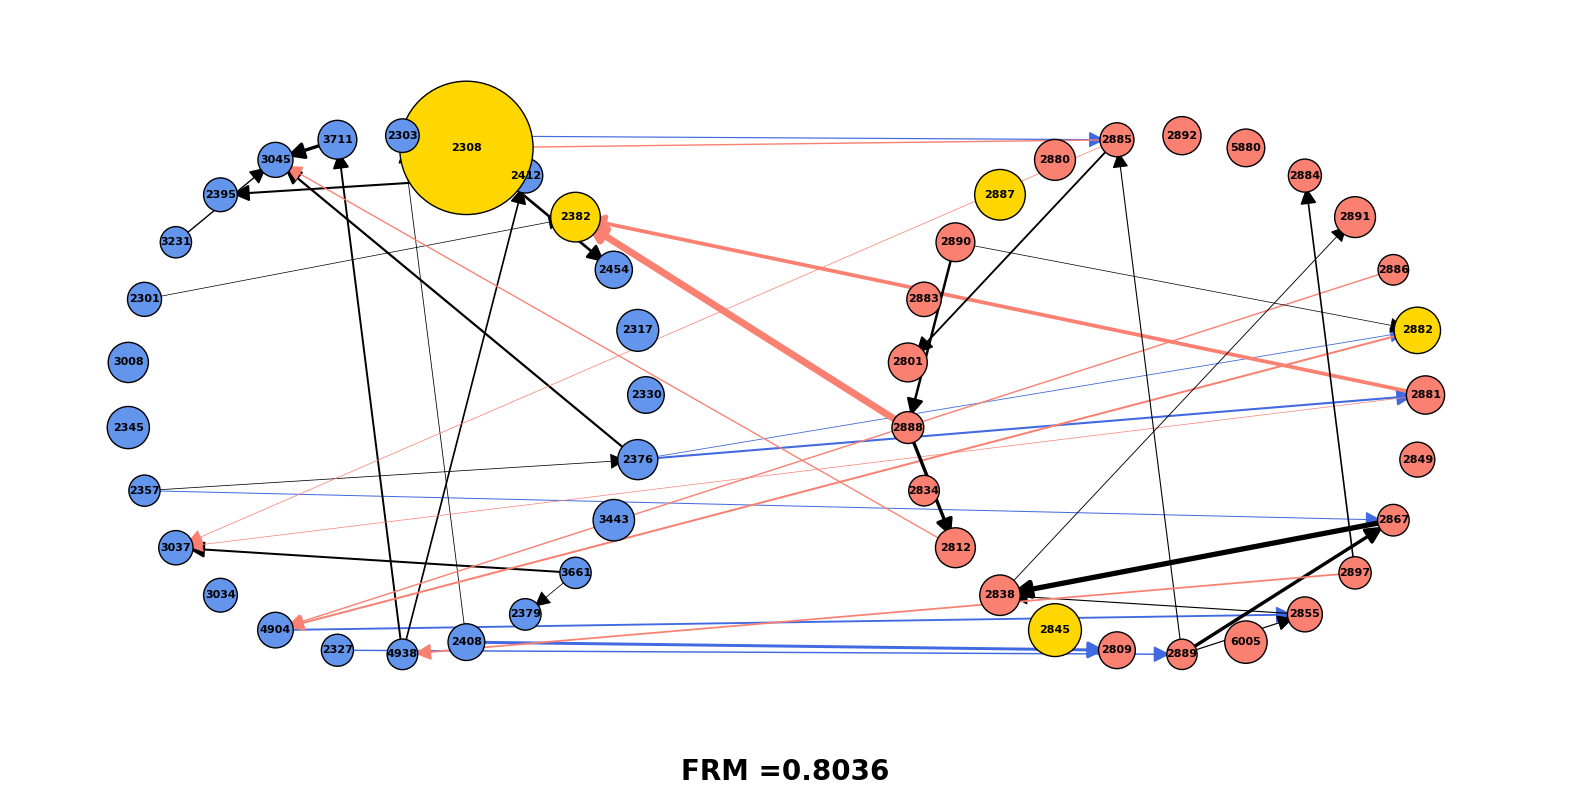

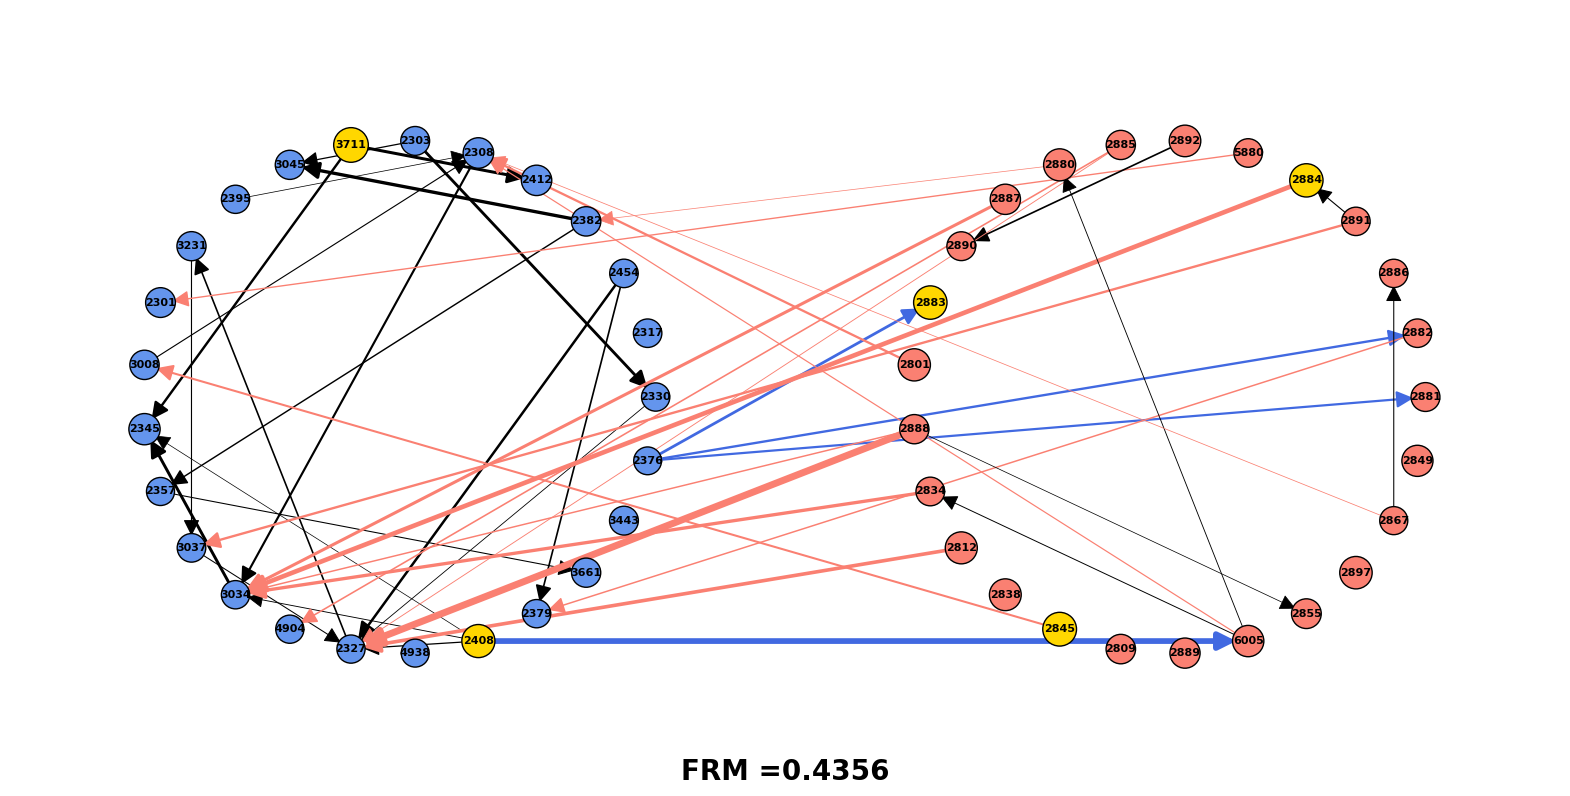

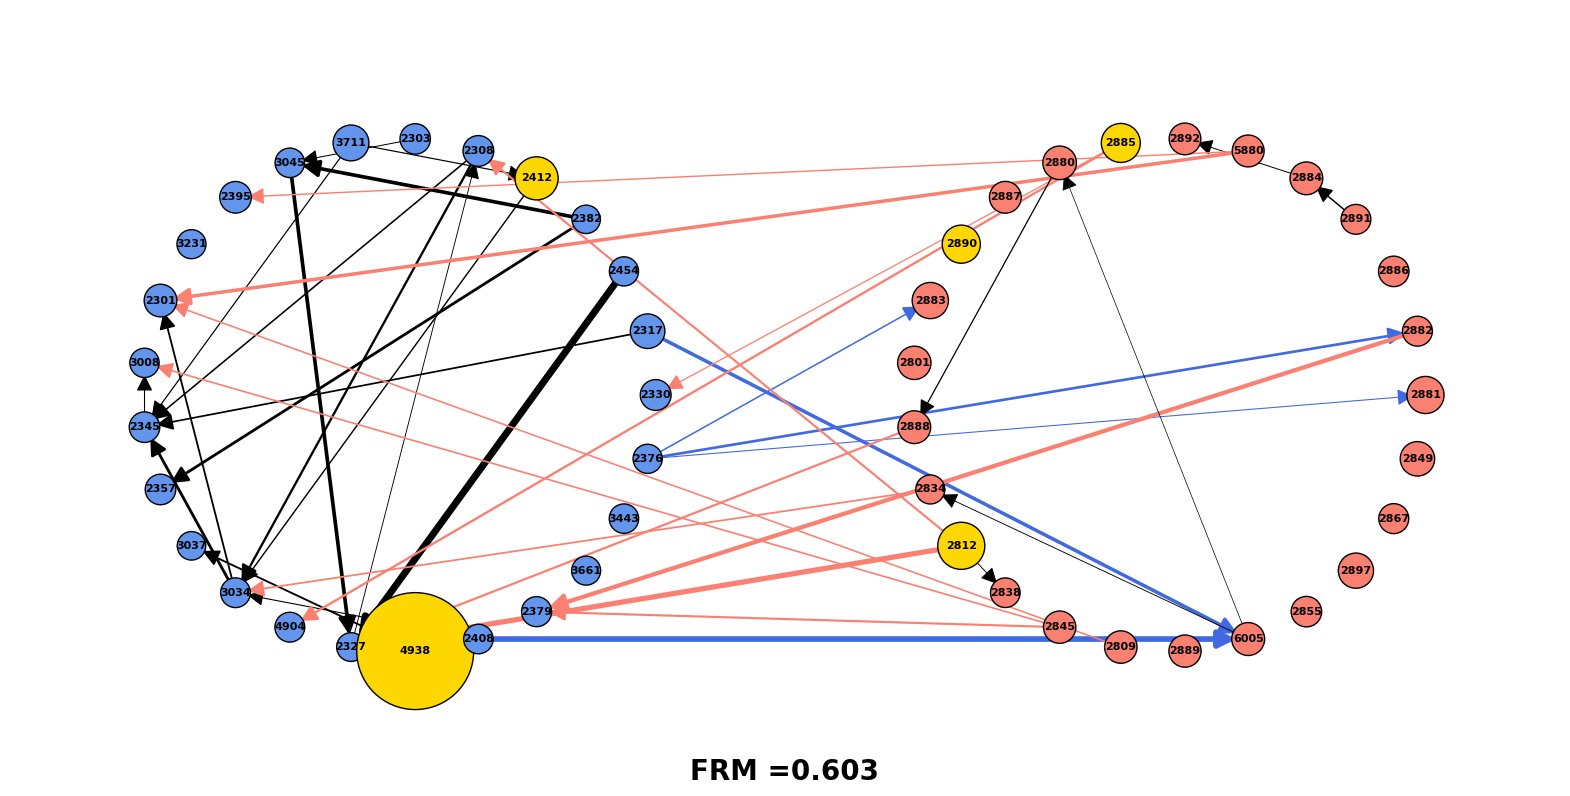

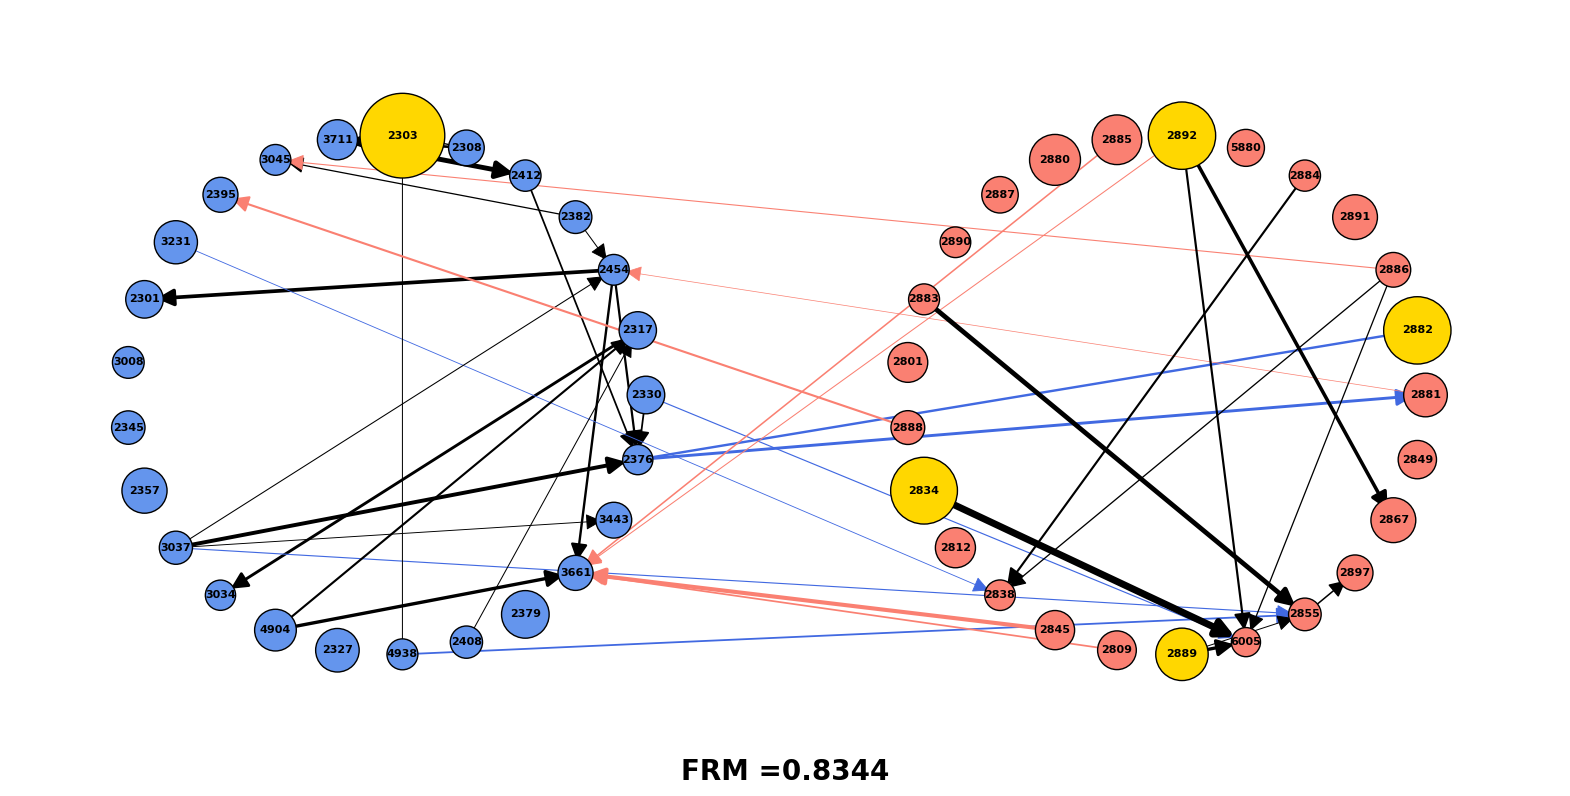

In [55]:
frames = []
special_date = pd.DataFrame({'2020-01-16','2020-01-30', '2021-06-25', '2022-08-08'})
special_date.columns = ['Date']
special_date.Date = pd.to_datetime(special_date.Date)

for date in special_date.Date:
    day = date.strftime('%Y%m%d')
    adj = pd.read_csv(f'Adj_matrix/Adj_matrix_{day}.csv')

    adj_flat = (adj.iloc[:, 1:]).select_dtypes(include=[np.number]).values.flatten()
    adj_flat = adj_flat[adj_flat != 0]
    quantile = np.percentile(abs(adj_flat), 95)

    G = nx.DiGraph()
    companies = adj['Company'].tolist()
    G.add_nodes_from(companies)
    for i, row in adj.iterrows():
        company_to = row['Company']
        for j in adj.columns[1:]:
            company_from = int(j)
            weight = row[j]             # beta of (i, j)
            if abs(weight) >= quantile:
                G.add_edge(company_from, company_to, weight=weight)

    cut = len(companies) // 2
    electronic = companies[:cut]
    financial = companies[cut:]
    electronic_pos = nx.circular_layout(electronic)
    financial_pos = nx.circular_layout(financial)

    for key, value in financial_pos.items():
        financial_pos[key] = value + np.array([3, 0])

    pos = {**electronic_pos, **financial_pos}

    weights = [abs(row[j]) for i, row in adj.iterrows() for j in adj.columns[1:] if row[j] != 0]

    edge_weights = abs(np.array([G[u][v]['weight'] for u, v in G.edges()]))
    edge_widths = 0.01 + 4.99 * (edge_weights - min(edge_weights)) / (max(edge_weights) - min(edge_weights))

    def get_edge_color(u, v, electronic, financial):
        if u in electronic and v in financial:
            return 'royalblue'
        elif u in financial and v in electronic:
            return 'salmon'
        else:
            return 'black'

    edge_colors = [get_edge_color(u, v, electronic, financial) for u, v in G.edges()]

    frm_values = frm.loc[date.strftime('%Y-%m-%d')].values
    top_frm_companies = frm.loc[date.strftime('%Y-%m-%d')].nlargest(5).index.tolist()

    node_colors = ['salmon' if company in financial else 'cornflowerblue' for company in companies]
    for top_company in top_frm_companies:
        node_colors[companies.index(int(top_company))] = 'gold'

    edge_weights = abs(np.array([G[u][v]['weight'] for u, v in G.edges()]))
    edge_widths = 0.5 + 4.5 * ((edge_weights - min(edge_weights)) / (max(edge_weights) - min(edge_weights)))

    norm_sizes = (frm_values - frm_flat.min()) / (frm_flat.max() - frm_flat.min())
    node_sizes = 400 + (norm_sizes ** 2) * 9600

    plt.figure(figsize=(20, 10))
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=edge_colors, arrowstyle='-|>', arrowsize=25)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    electronic_label_pos = np.mean(list(electronic_pos.values()), axis=0) + np.array([0, 1.2])
    financial_label_pos = np.mean(list(financial_pos.values()), axis=0) + np.array([0, 1.2])

    # plt.text(electronic_label_pos[0], electronic_label_pos[1], 'Electronic', horizontalalignment='center', fontsize=16, fontweight='bold')
    # plt.text(financial_label_pos[0], financial_label_pos[1], 'Financial', horizontalalignment='center', fontsize=16, fontweight='bold')  # Changed 'Financial' to 'Salmon'
    # plt.text(0.5, 0, '[ '+date.strftime('%Y-%m-%d'+' ]'), transform=plt.gca().transAxes, horizontalalignment='center', fontsize=20, fontweight='bold')
    plt.text(0.5, 0, 'FRM =' + str(frm.mean(axis=1)[day].round(4)), transform=plt.gca().transAxes, horizontalalignment='center', fontsize=20, fontweight='bold')

    plt.axis('equal') 
    plt.axis('off')
    plt.savefig(f'Adj_matrix_graphical_overleaf/Adj_matrix_graphical_{day}.png', bbox_inches='tight', transparent=True, dpi=144)
    plt.show()